In [1]:
import wget
import os
import pandas as pd
import numpy as np
import csv
import urllib.request
from io import StringIO
import warnings
import re

## Lista de EEUU

En primer lugar accedemos a las urls con las listas de sancionados de EEUU en formato .csv y .xml y las guardamos en local. Cada vez que este proceso es ejecutado, se borran los archivos antiguos en nuestro directorio local y se vuelven a cargar desde la web.

In [2]:
urls = ['https://www.treasury.gov/ofac/downloads/sdn.csv',
        'https://www.treasury.gov/ofac/downloads/add.csv',
        'https://www.treasury.gov/ofac/downloads/sdn.xml']

path = 'UE_EEUU_data_crudo'

for url in urls:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.

-1 / unknown

A continuación cargamos los .csv con la información de sancionados de EEUU en dos DataFrames relacionados por la columna 'uid', que es la clave primaria del DataFrame df_sdn y la foránea del otro. De estos .csv se seleccionan las columnas relevantes para nuestro estudio. Las columnas de los .csv no vienen etiquetadas con un nombre. Es necesario buscar el nombre correspondiente a cada columna en el .xml, que es el archivo con la información general, y escribirlo.

In [3]:
df_sdn = pd.read_csv('UE_EEUU_data_crudo/sdn.csv',usecols=list(range(3)),header=None).dropna()
df_sdn.columns = ['uid','LastName','sdnType']
df_sdn.head()

,uid,LastName,sdnType
0,36,AEROCARIBBEAN AIRLINES,-0-
1,173,"ANGLO-CARIBBEAN CO., LTD.",-0-
2,306,BANCO NACIONAL DE CUBA,-0-
3,424,BOUTIQUE LA MAISON,-0-
4,475,CASA DE CUBA,-0-


In [4]:
df_add = pd.read_csv('UE_EEUU_data_crudo/add.csv',header=None,usecols=list(range(5))).dropna()
df_add.columns = ['uid','uid_pk_add','Address','City','Country']
df_add.drop(columns=['uid_pk_add'],axis=1,inplace=True)
df_add.head()

,uid,Address,City,Country
0,36,-0-,Havana,Cuba
1,173,"Ibex House, The Minories",London EC3N 1DY,United Kingdom
2,306,Zweierstrasse 35,Zurich CH-8022,Switzerland
3,306,Avenida de Concha Espina 8,Madrid E-28036,Spain
4,306,"Dai-Ichi Bldg. 6th Floor, 10-2 Nihombashi, 2-c...",Tokyo 103,Japan


Se hace inner join a las dos tablas. Como la columna del uid ya no es necesaria despues del join, se puede eliminar. Los valores nulos llevan el valor '-0- ', por lo que se puede sustituir por NaN, que es el nombre del valor nulo para Python. El DataFrame de EEUU con la información relevante queda como:

In [5]:
df_eeuu = pd.merge(df_sdn,df_add,how='inner',on='uid').drop(columns=['uid'],axis=1).replace({'-0- ':np.nan})
df_eeuu.head()

,LastName,sdnType,Address,City,Country
0,AEROCARIBBEAN AIRLINES,NaN,NaN,Havana,Cuba
1,"ANGLO-CARIBBEAN CO., LTD.",NaN,"Ibex House, The Minories",London EC3N 1DY,United Kingdom
2,BANCO NACIONAL DE CUBA,NaN,Zweierstrasse 35,Zurich CH-8022,Switzerland
3,BANCO NACIONAL DE CUBA,NaN,Avenida de Concha Espina 8,Madrid E-28036,Spain
4,BANCO NACIONAL DE CUBA,NaN,"Dai-Ichi Bldg. 6th Floor, 10-2 Nihombashi, 2-c...",Tokyo 103,Japan


In [6]:
df_eeuu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 15264
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   LastName  15265 non-null  object
 1   sdnType   8096 non-null   object
 2   Address   8230 non-null   object
 3   City      10043 non-null  object
 4   Country   12848 non-null  object
dtypes: object(5)
memory usage: 715.5+ KB


In [7]:
print("La columna con la información del nombre de la entidad es 'LastName'.\n")

print("Se trata de una variable categórica nominal con",
      len(df_eeuu['LastName'].unique()),"valores únicos.\n")

print("Existen",df_eeuu['LastName'].isnull().tolist().count(True),
      "valores nulos de un total de",len(df_eeuu),'valores.')

La columna con la información del nombre de la entidad es 'LastName'.

Se trata de una variable categórica nominal con 10459 valores únicos.

Existen 0 valores nulos de un total de 15265 valores.


In [8]:
print("La columna con la información del tipo de entidad es 'sdnType'.\n")

print("Se trata de una variable categórica nominal con",
      len(df_eeuu['sdnType'].unique()),"valores únicos.\n")

print("Existen",df_eeuu['sdnType'].isnull().tolist().count(True),
      "valores nulos de un total de",len(df_eeuu),'valores.')


La columna con la información del tipo de entidad es 'sdnType'.

Se trata de una variable categórica nominal con 4 valores únicos.

Existen 7169 valores nulos de un total de 15265 valores.


In [9]:
print("Las columnas con la información de la ubicación son 'Address', 'City' y 'Country'.\n")

print("Se tratan de variables categóricas nominales con",
      len(df_eeuu['Address'].unique()),",",len(df_eeuu['City'].unique()),"y",len(df_eeuu['Country'].unique()),
      "valores únicos, respectivamente.\n")

print("Existen",df_eeuu['Address'].isnull().tolist().count(True),
      "valores nulos para 'Address',",df_eeuu['City'].isnull().tolist().count(True),
      "para 'City' y",df_eeuu['Country'].isnull().tolist().count(True),
      "para 'Country' de un total de",len(df_eeuu),"valores.")

Las columnas con la información de la ubicación son 'Address', 'City' y 'Country'.

Se tratan de variables categóricas nominales con 7111 , 3466 y 179 valores únicos, respectivamente.

Existen 7035 valores nulos para 'Address', 5222 para 'City' y 2417 para 'Country' de un total de 15265 valores.


Hay demasiados valores nulos en la columna 'sdnType'. Veamos cuales son sus valores únicos:

In [10]:
df_eeuu['sdnType'].unique()

array([nan, 'individual', 'vessel', 'aircraft'], dtype=object)

El tipo de sancionado puede deducirse a partir del nombre del sancionado. Para ello, se crea un bucle que devuelve el nombre de todos los sancionados cuya columna 'sdnType' es nula.

In [11]:
for i in range(len(df_eeuu[df_eeuu['sdnType'].isnull()])):
    df = df_eeuu[df_eeuu['sdnType'].isnull()].reset_index(drop=True)
    print(df.loc[i,'LastName'])

AEROCARIBBEAN AIRLINES
ANGLO-CARIBBEAN CO., LTD.
BANCO NACIONAL DE CUBA
BANCO NACIONAL DE CUBA
BANCO NACIONAL DE CUBA
BANCO NACIONAL DE CUBA
BOUTIQUE LA MAISON
CASA DE CUBA
CASA DE CUBA
CECOEX, S.A.
CIMEX
CIMEX IBERICA
CIMEX, S.A.
COMERCIAL IBEROAMERICANA, S.A.
COMERCIAL CIMEX, S.A.
COMERCIAL DE RODAJES Y MAQUINARIA, S.A.
COMERCIALIZACION DE PRODUCTOS VARIOS
COMPANIA DE IMPORTACION Y EXPORTACION IBERIA
CORPORACION CIMEX, S.A.
COTEI
CRYMSA - ARGENTINA, S.A.
CUBACANCUN CIGARS AND GIFT SHOPS
CUBAEXPORT
CUBAFRUTAS
CUBAN CIGARS TRADE
CUBANATUR
CUBATABACO
CUMEXINT, S.A.
DELVEST HOLDING, S.A.
EDICIONES CUBANAS
EDYJU, S.A.
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION
EMPRESA CUBANA DE AVIACION

GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
GLOBAL RELIEF FOUNDATION, INC.
JEMAA ISLAMIYAH
AGRICOLA DOIMA DEL NORTE DEL VALLE LTDA.
AGRICOLA DOIMA DEL NORTE DEL VALLE LTDA.
AGROPECUARIA MIRALINDO S.A.
ARIZONA S.A.
GANADERIA EL VERGEL LTDA.
GANADERIA EL VERGEL LTDA.
GANADERIAS BILBAO LTDA.
GANADERIAS BILBAO LTDA.
INMOBILIARIA EL ESCORIAL LTDA.
INMOBILIARIA EL ESCORIAL LTDA.
INMOBILIARIA LINARES LTDA.
INMOBILIARIA PASADENA LTDA.
INVERSIONES LA QUINTA Y CIA. LTDA.
INVERSIONES LA QUINTA Y CIA. LTDA.
LADRILLERA LA CA

I.P.C. INTERNATIONAL LIMITED
I.P.C. MARKETING LIMITED
INVESTACAST PRECISION CASTINGS, LTD.
IRAQI ALLIED SERVICES LIMITED
IRAQI FREIGHT SERVICES LIMITED
IRAQI TRADE CENTER
JARACO S.A.
KEENCLOUD LIMITED
MEED INTERNATIONAL LIMITED
ORIENT SHIPPING LIMITED
PANDORA SHIPPING CO. S.A.
PETRA NAVIGATION & INTERNATIONAL TRADING CO. LTD.
RAJBROOK LIMITED
REYNOLDS AND WILSON, LTD.
T N K FABRICS LIMITED
T.E.G. LIMITED
T.M.G. ENGINEERING LIMITED
TARIQ ABU SHANAB EST. FOR TRADE & COMMERCE
TECHNOLOGY AND DEVELOPMENT GROUP LTD
TIGRIS TRADING, INC.
TIGRIS TRADING, INC.
TRADING & MARITIME INVESTMENTS
U.I. INTERNATIONAL
WHALE SHIPPING LTD.
A.T.E. INTERNATIONAL LTD.
BLOTO INTERNATIONAL COMPANY
BLOTO INTERNATIONAL COMPANY
BLOTO INTERNATIONAL COMPANY
BLOTO INTERNATIONAL COMPANY
MELFI MARINE CORPORATION S.A.
MELFI MARINE CORPORATION S.A.
MELFI MARINE CORPORATION S.A.
MELFI MARINE CORPORATION S.A.
AL-HARAMAIN FOUNDATION : COMOROS ISLANDS
ISLAMIC AFRICAN RELIEF AGENCY
INTERCONTINENTAL DE AVIACION S.A.
ACCIRENT S

KALAYE ELECTRIC COMPANY
HIGHER INSTITUTE OF APPLIED SCIENCE AND TECHNOLOGY
ELECTRONICS INSTITUTE
NATIONAL STANDARDS AND CALIBRATION LABORATORY
SNIPER AFRICA
SNIPER AFRICA
SNIPER AFRICA
SNIPER AFRICA
BUTEMBO AIRLINES
BUTEMBO AIRLINES
CONGOCOM TRADING HOUSE
MACHANGA LTD.
UGANDA COMMERCIAL IMPEX
UGANDA COMMERCIAL IMPEX
DEFENSE INDUSTRIES ORGANIZATION
INVERSIONES MPS S.A.
PROYECTOS Y SOLUCIONES INMOBILIARIA LTDA.
GERENCIA DE PROYECTOS Y SOLUCIONES LTDA.
CONSTRUCTORA AMERICA S.A.
ORIMAR LTDA.
AUDITORES ESPECIALIZADOS LTDA.
HOTEL LA CASCADA S.A.
INVERSIONES Y REPRESENTACIONES S.A.
TRANSPORTES MICHAEL LTDA.
TRANSPORTES MICHAEL LTDA.
COOPERATIVA DE SERVICIO DE TRANSPORTE DE CARGA DE COLOMBIA LTDA.
COOPERATIVA DE SERVICIO DE TRANSPORTE DE CARGA DE COLOMBIA LTDA.
CASTRO CURE Y CIA. S. EN C.
CURE SABAGH Y CIA. S.C.S.
FUDIA LTDA.
CABLES NACIONALES S.A.
INVERSIONES AGROPECUARIA ARIZONA LTDA.
VERANILLO DIVE CENTER LTDA.
MARTIN HODWALKER M. & CIA. S. EN C.
DESARROLLO GEMMA CORPORATION
ROCK FISH IMPOR

SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
SIN-MEX IMPORTADORA, S.A. DE C.V.
COMERCIAL JOANA, S.A. DE C.V.
COMERCIAL JOANA, S.A. DE C.V.
COMERCIAL JOANA, S.A. DE C.V.
COMERCIAL JOANA, S.A. DE C.V.
COMERCIALIZADORA BRIMAR'S, S.A. DE C.V.
COMERCIALIZADORA TOQUIN, S.A. DE C.V.
COMERCIALIZADORA TOQUIN, S.A. DE C.V.
COMERCIALIZADORA TOQUIN, S.A. DE C.V.
COMERCIALIZADORA TOQUIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
COMERCIALIZADORA JALSIN, S.A. DE C.V.
CO

KATA'IB HIZBALLAH
CONSULTORIA EN CAMBIOS FALCON S.A. DE C.V.
CONSULTORIA EN CAMBIOS FALCON S.A. DE C.V.
HIERROS DE JERUSALEM S.A.
TAXI AEREO ANTIOQUENO S.A.
LLANOTOUR LTDA.
AGROGANADERA LOS SANTOS S.A.
AGROESPINAL S.A.
AERONAUTICA CONDOR S.A. DE C.V.
AERONAUTICA CONDOR S.A. DE C.V.
AERONAUTICA CONDOR DE PANAMA, S.A.
GRUPO FALCON DE PANAMA, S.A.
GRUPO FALCON S.A.
GRUPO GUADALEST S.A. DE C.V.
GRUPO GUADALEST S.A. DE C.V.
FRANZUL S.A.
CONSTRUCTORA GUADALEST S.A.
ASES DE COMPETENCIA Y CIA. S.A.
ASES DE COMPETENCIA Y CIA. S.A.
ASES DE COMPETENCIA Y CIA. S.A.
REVOLUTIONARY STRUGGLE
HAJI JUMA KHAN ORGANIZATION
HAJI JUMA KHAN ORGANIZATION
CUMBRES SOLUCIONES INMOBILIARIAS S.A. DE C.V.
CUMBRES SOLUCIONES INMOBILIARIAS S.A. DE C.V.
CIMIENTOS LA TORRE S.A. DE C.V.
CORPORACION DE CONSULTORIA, ASESORIA, PRESTACION DE SERVICIOS Y DOTACION DE ELEMENTOS Y SUMINISTROS CIA. LIMITADA
HODWALKER Y LEAL Y CIA. S.C.A.
NAMCHONGANG TRADING CORPORATION
NAMCHONGANG TRADING CORPORATION
HONG KONG ELECTRONICS
VARIED

MELRUX RICA S PIZZA
MELRUX RICA S PIZZA
AMG RICAS PIZZA
OBRAS, SERVICIOS Y MANTENIMIENTOS C.A.
MOJETE PARRILLA
INVERSIONES MINERAS H.D. EMPRESA UNIPERSONAL
INVERSIONES MINERAS H.D. EMPRESA UNIPERSONAL
CIA. AGROINDUSTRIAL PALMERA S.A.
7 KARNES
TAJCO
TAJCO
TAJCO
TAJCO
TAJCO
TAJCO
GOLFRATE HOLDINGS (ANGOLA) LDA
GOLFRATE HOLDINGS (ANGOLA) LDA
GOLFRATE HOLDINGS (ANGOLA) LDA
CONGO FUTUR
CONGO FUTUR
KAIRABA SUPERMARKET
KAIRABA SUPERMARKET
KAIRABA SUPERMARKET
OVLAS TRADING S.A.
OVLAS TRADING S.A.
GRUPO AROSFRAN EMPREENDIMENTOS E PARTICIPACOES SARL
GRUPO AROSFRAN EMPREENDIMENTOS E PARTICIPACOES SARL
GRUPO AROSFRAN EMPREENDIMENTOS E PARTICIPACOES SARL
GRUPO AROSFRAN EMPREENDIMENTOS E PARTICIPACOES SARL
GRUPO AROSFRAN EMPREENDIMENTOS E PARTICIPACOES SARL
AFRI BELG COMMERCIO E INDUSTRIA LDA
AFRI BELG COMMERCIO E INDUSTRIA LDA
ELLISSA HOLDING
SOLMAR
ELLISSA GROUP SA
AGROPHEN
ELLISSA SHIPPING
YAMEN BENIN SARL
ELLISSA PARC COTONOU
ELLISSA MEGASTORE
ELLISSA MEGASTORE
ALMACEN JUNIOR
ALMACEN JUNIOR NO. 

HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
HAJI KHAIRULLAH HAJI SATTAR MONEY EXCHANGE
SERVICIOS CHULAVISTA, S.A. DE C.V.
SERVICIOS CHULAVISTA, S.A. DE C.V.
ADT PETROSERVICIOS, S.A. DE C.V.
ADT PETROSERVICIOS, S.A. DE C.V.
ADT PETROSERVICIOS, S.A. DE C.V.
ADT PETROSERVI

PARS OIL CO.
PARS OIL CO.
COMMERCIAL PARS OIL CO.
MARJAN PETROCHEMICAL COMPANY
MARJAN PETROCHEMICAL COMPANY
GHADIR INVESTMENT COMPANY
GHADIR INVESTMENT COMPANY
SADAF PETROCHEMICAL ASSALUYEH COMPANY
SADAF PETROCHEMICAL ASSALUYEH COMPANY
POLYNAR COMPANY
ONE CLASS PROPERTIES (PTY) LTD.
ONE VISION INVESTMENTS 5 (PTY) LTD.
ONE VISION INVESTMENTS 5 (PTY) LTD.
PARS MCS
PARS MCS
PARS MCS
OIL INDUSTRY INVESTMENT COMPANY
REY NIRU ENGINEERING COMPANY
DAEDONG CREDIT BANK
DAEDONG CREDIT BANK
DCB FINANCE LIMITED
DCB FINANCE LIMITED
AVUAR OOO
SWISS MANAGEMENT SERVICES SARL
KASB INTERNATIONAL LLC
PETRO ROYAL FZE
AA ENERGY FZCO
GANADEROS AGRICULTORES DEL NORTE, S. DE R.L. DE C.V.
GANADEROS AGRICULTORES DEL NORTE, S. DE R.L. DE C.V.
GANADEROS AGRICULTORES DEL NORTE, S. DE R.L. DE C.V.
GANADEROS AGRICULTORES DEL NORTE, S. DE R.L. DE C.V.
PALMA DEL BAJO AGUAN, S.A.
PALMA DEL BAJO AGUAN, S.A.
PALMA DEL BAJO AGUAN, S.A.
MINERA MI ESPERANZA, S.A.
MINERA MI ESPERANZA, S.A.
INMOBILIARIA RIVERA MARADIAGA, S.A. 

ASMA MONEY EXCHANGERS
ASMA MONEY EXCHANGERS
MUJAHIDIN SHURA COUNCIL IN THE ENVIRONS OF JERUSALEM
THE ORGANIZATION OF DEFENSIVE INNOVATION AND RESEARCH
GARCES Y BEDOYA CIA. LTDA
CASPIAN AIRLINES
CASPIAN AIRLINES
MERAJ AIR
ASIAN AVIATION LOGISTICS COMPANY LIMITED
PIONEER LOGISTICS
JAHAN TECH ROOYAN PARS
MANDEGAR BASPAR KIMIYA COMPANY
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICULTURAL COOPERATIVE BANK
AGRICU

VTB BANK AZERBAIJAN OPEN JOINT STOCK COMPANY
BANCO VTB AFRICA SA
VTB BANK GEORGIA JOINT STOCK COMPANY
VTB CAPITAL HOLDINGS CLOSED JOINT STOCK COMPANY
VTB CAPITAL HOLDINGS CLOSED JOINT STOCK COMPANY
VTB CAPITAL HOLDINGS CLOSED JOINT STOCK COMPANY
VTB PENSION ADMINISTRATOR LIMITED
LIMITED LIABILITY COMPANY VTB DC
LIMITED LIABILITY COMPANY VTB DC
VTB FACTORING LTD
NPF VTB PENSION FUND JOINT STOCK COMPANY
VTB SPECIALIZED DEPOSITORY CLOSED JOINT STOCK COMPANY
VTB REGISTRAR CLOSED JOINT STOCK COMPANY
AUCTION LIMITED LIABILITY COMPANY
AUCTION LIMITED LIABILITY COMPANY
JOINT STOCK COMPANY SBERBANK AUTOMATED TRADE SYSTEM
JOINT STOCK COMPANY SBERBANK AUTOMATED TRADE SYSTEM
LIMITED LIABILITY COMPANY SBERBANK FINANCIAL COMPANY
LIMITED LIABILITY COMPANY ACTIVE BUSINESS CONSULT
JOINT STOCK COMPANY SBERBANK PRIVATE PENSION FUND
INSURANCE COMPANY SBERBANK INSURANCE LIMITED LIABILITY COMPANY
INSURANCE COMPANY SBERBANK INSURANCE LIMITED LIABILITY COMPANY
INSURANCE COMPANY SBERBANK INSURANCE LIMITED LIAB

AYDAH TRADING LLC
AYDAH TRADING LLC
AYDAH TRADING LLC
WADI AL AFRAH TRADING LLC
WADI AL AFRAH TRADING LLC
WADI AL AFRAH TRADING LLC
MINISTRY OF STATE SECURITY PRISONS BUREAU
MINISTRY OF PEOPLE'S SECURITY CORRECTIONAL BUREAU
ISIL-SAUDI ARABIA
ISIL-SAUDI ARABIA
ISIL-LIBYA
ISIL-YEMEN
AVICAL S.A.
AVICAL S.A.
AVICAL S.A.
AVICAL S.A.
AVICAL S.A.
INVERSIONES LA PLATA M & M S. EN C.A.
INVERSIONES LA PLATA M & M S. EN C.A.
ROMIK S.A.
GEMUHO HOLDING, INC
UNIREFRICLIMA S.A.
MUNSA INTERNATIONAL INVESMENTS S.A.
JAMA'AT UL DAWA AL-QU'RAN
TARIQ GIDAR GROUP
TARIQ GIDAR GROUP
TARIQ GIDAR GROUP
TARIQ GIDAR GROUP
TARIQ GIDAR GROUP
TARIQ GIDAR GROUP
KAY ZONE GENERAL TRADING LLC
KAY ZONE BUILDERS & DEVELOPERS
LANDTEK DEVELOPERS
UNICO TEXTILES
KHALID BIN AL-WALID ARMY
PJSC MOSTOTREST
PJSC MOSTOTREST
SGM MOST OOO
MAHROUS TRADING FZE
MAHROUS GROUP
MAHROUS GROUP
MINISTRY OF PEOPLE'S SECURITY
ORGANIZATION AND GUIDANCE DEPARTMENT
MINISTRY OF STATE SECURITY
AL-QA'IDA IN THE INDIAN SUBCONTINENT
AL-QA'IDA IN THE IN

KOREA COMPUTER CENTER
KOREA COMPUTER CENTER
KOREA COMPUTER CENTER
KOREA COMPUTER CENTER
KOREA COMPUTER CENTER
KOREA COMPUTER CENTER
SONGI TRADING COMPANY
KOREA ZINC INDUSTRIAL GROUP
KOREA ZINC INDUSTRIAL GROUP
KPSK, OOO
MOLOT-ORUZHIE, OOO
OBORONLOGISTIKA OOO
OBORONLOGISTIKA OOO
RIVIERA SUNRISE RESORT & SPA
IFDK, ZAO
AL-KAWTHAR MONEY EXCHANGE
MAJELIS MUJAHIDIN INDONESIA
CENTRAL REPUBLIC BANK
STATE BANK LUHANSK PEOPLE'S REPUBLIC
TSMRBANK, OOO
TAATTA, AO
TAATTA, AO
TAATTA, AO
TAATTA, AO
JOINT STOCK COMPANY BLACK SEA BANK OF DEVELOPMENT AND RECONSTRUCTION
JOINT STOCK COMMERCIAL BANK RUBLEV
JOINT STOCK COMMERCIAL BANK RUBLEV
JOINT STOCK COMMERCIAL BANK RUBLEV
JOINT-STOCK COMPANY COMMERCIAL BANK NORTH CREDIT
JOINT-STOCK COMPANY COMMERCIAL BANK NORTH CREDIT
JOINT-STOCK COMPANY COMMERCIAL BANK NORTH CREDIT
IS BANK, AO
IS BANK, AO
IS BANK, AO
IS BANK, AO
VVB, PAO
VVB, PAO
VVB, PAO
VVB, PAO
LIMITED LIABILITY COMPANY CONCORD MANAGEMENT AND CONSULTING
CONCORD CATERING
CONCORD CATERING
PRIVATE MILI

KINGS ROMANS INTERNATIONAL INVESTMENT CO. LIMITED
KING ROMANS COMPANY LIMITED
KING ROMANS COMPANY LIMITED
KING ROMANS COMPANY LIMITED
BLUE LAGOON GROUP LTD.
KANSO FISHING AGENCY LIMITED
STAR TRADE GHANA LIMITED
GOLDEN FISH LIBERIA LTD.
GOLDEN FISH S.A.L. (OFFSHORE)
DOLPHIN TRADING COMPANY LIMITED
SKY TRADE COMPANY
CHONMYONG SHIPPING CO
CHONMYONG SHIPPING CO
HAPJANGGANG SHIPPING CORP
KOREA ACHIM SHIPPING CO
KOREA ANSAN SHIPPING COMPANY
PROFESYONELLER ELEKTRONIK
KOREA UNPHA SHIPPING & TRADING
KOREA MYONGDOK SHIPPING CO
KOREA SAMJONG SHIPPING CO
KOREA SAMMA SHPG CO
KOREA YUJONG SHIPPING CO LTD
PAEKMA SHIPPING CO
PHYONGCHON SHIPPING & MARINE
POCHON SHIPPING & MANAGEMENT
SONGWON SHIPPING & MANAGEMENT
AL-MUTAFAQ COMMERCIAL COMPANY
LIIBAAN TRADING
TONGHUNG SHIPPING & TRADING CO
MYOHYANG SHIPPING CO
FIRST OIL JV CO LTD
CHANG AN SHIPPING & TECHNOLOGY
HONGXIANG MARINE HONG KONG LTD
SHEN ZHONG INTERNATIONAL SHPG
LIBERTY SHIPPING CO LTD
WEIHAI WORLD-SHIPPING FREIGHT
HUAXIN SHIPPING HONGKONG LTD
SH

AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
AL HARAM FOREIGN EXCHANGE CO. LTD
ESFAHAN'S MOBARAKEH STEEL COMPANY
ESFAHAN'S MOBARAKEH STEEL COMPANY
ESFAHAN'S MOBARAKEH STEEL COMPANY
ANDISHEH MEHVARAN INVESTMENT COMPANY
PARSIAN BANK
SINA BANK
SINA BANK
SINA BANK
SINA BANK
SINA BANK
SINA BANK
BAHMAN GROUP
AFAQ DUBAI
AVERUCA, C.A.
QUIANA TRADING LIMITED
PANAZEATE SL
PANAZEATE SL
KRYMTETS, AO
LIMITED LIABILITY COMPANY INFRASTRUCTURE PROJECTS MANAGEMENT COMPANY
IYARI
IYARI
BODECARNE, S.A. DE C.V.
SIERRA GAS S.A.L. OFFSHORE
LAMA FOODS S.A.R.L.
LAMA FOODS INTERNATIONAL O

A.S.P. BUILDERS
BAGHMISHEH RESIDENTIAL DEVELOPMENT
BEHSAZAN PARS EQUIPMENT DEVELOPMENT
AZERBAIJAN CONSTRUCTION
GHADIR KHUZESTAN CONSTRUCTION INDUSTRY DEVELOPMENT
FARS SARPANAH
PARS SAZEH ENGINEERING AND CONSTRUCTION
GHADIR PAYMAN COUNSELING ENGINEERS
KISH ROOYA-E ZENDEGI
OFOQ SAZEH PAYAH
TISA KISH
NARENJESTAN HOTEL AND BUILDING DEVELOPMENT
MOMTAZ ELECTRIC
PAYVAR ANDISH
MOTOJEN AUTO INDUSTRY COMPANY
KARAMAAD SYSTEMS MANAGEMENT
HAMOON SEPAHAN INVESTMENT
VASEPARI SEPEHR PARS
HAMOON SEPAHAN MANAGEMENT SERVICES
PARS PAIDAR SANAT NOVIN
SHIRAZ PARS FARAYAND OIL REFINERY
AZAR INVESTMENT
HAMOON SEPAHAN COMMERCIAL TRADING
DAY INVESTMENT
KISH ASIA NAVAK
SEPAHAN CEMENT
SOUTH IRAN DARYABAN KISH
SEPAHAN CEMENT INVESTMENT
SEPAHAN CEMENT CONCRETE PRODUCTS
IRAN MERINE SERVICES
SEPAHAN CEMENT RAHNAVARD PRODUCTS TRANSPORTATION
PARSIAN RAIL TRANSPORT DEVELOPMENT
MAPNA KHUZESTAN ELECTRICITY GENERATION
GHADIR OXIN ELECTRICITY GENERATION DEVELOPMENT
GHADIR ABU MUSA HAMOON
SEPAHAN CEMENT PAKAT-SAZI SHAFAGH
QO

FOZ FOR TRADING
AL-MOHAIMEN FOR TRANSPORTING & CONTRACTING
ORIENT CLUB
FOUR SEASONS DAMASCUS
LANA TV
SYNERGY SAL OFFSHORE
JUI PANG SHIPPING CO LTD
JUI PANG SHIPPING CO LTD
JUI PANG SHIPPING CO LTD
JUI PANG SHIPPING CO LTD
JUI CHENG SHIPPING COMPANY LIMITED
JUI CHENG SHIPPING COMPANY LIMITED
JUI ZONG SHIP MANAGEMENT CO LTD
JUI ZONG SHIP MANAGEMENT CO LTD
CUBAMETALES
CUBAMETALES
BALOCHISTAN LIBERATION ARMY
MULTITEX INTERNATIONAL TRADING, S.A.
GLOBAL STRUCTURE, S.A.
EMMR & CIA. S.A.S.
C I FONDO GLOBAL DE ALIMENTOS LTDA
GROUP GRAND LIMITED, S.A. DE C.V.
GROUP GRAND LIMITED
GROUP GRAND LIMITED GENERAL TRADING
ASASI FOOD FZE
ASASI FOOD FZE
ASASI FOOD FZE
GENERAL DIRECTORATE OF MILITARY COUNTERINTELLIGENCE
BAKHTAR RAAD SEPAHAN COMPANY
TAWU MECHANICAL ENGINEERING AND TRADING COMPANY
SANMING SINO-EURO IMPORT AND EXPORT CO., LTD
HENAN JIAYUAN ALUMINIUM INDUSTRY CO., LTD
HENAN JIAYUAN ALUMINIUM INDUSTRY CO., LTD
TAMIN KALAYE SABZ ARAS COMPANY
SUZHOU ZHONGSHENG MAGNETIC INDUSTRY CO., LTD.
SUZHOU Z

SOUTH KAVEH STEEL COMPANY
SOUTH KAVEH STEEL COMPANY
SOUTH KAVEH STEEL COMPANY
CHADORMALU MINING & INDUSTRIAL COMPANY
OXIN STEEL COMPANY
ARFA IRON AND STEEL COMPANY
ARFA IRON AND STEEL COMPANY
IRAN ALLOY STEEL COMPANY
IRAN ALLOY STEEL COMPANY
KHOUZESTAN STEEL COMPANY
KHOUZESTAN STEEL COMPANY
ALMAHDI ALUMINUM CO.
ALMAHDI ALUMINUM CO.
NATIONAL IRANIAN COPPER INDUSTRIES COMPANY
NATIONAL IRANIAN COPPER INDUSTRIES COMPANY
GOLGOHAR MINING AND INDUSTRIAL COMPANY
GOLGOHAR MINING AND INDUSTRIAL COMPANY
GOLGOHAR MINING AND INDUSTRIAL COMPANY
IRANIAN GHADIR IRON & STEEL CO.
IRANIAN GHADIR IRON & STEEL CO.
REPUTABLE TRADING SOURCE LLC
REPUTABLE TRADING SOURCE LLC
ALWEFAQ LTD
ALWEFAQ LTD
SABA STEEL
HORMOZGAN STEEL COMPANY
IRAN ALUMINUM COMPANY
IRAN ALUMINUM COMPANY
KHALAGH TADBIR PARS CO.
HONGYUAN MARINE CO LTD
HONGYUAN MARINE CO LTD
PAMCHEL TRADING BEIJING CO. LTD.
PAMCHEL TRADING BEIJING CO. LTD.
PAMCHEL TRADING BEIJING CO. LTD.
POWER ANCHOR LIMITED
SAGE ENERGY HK LIMITED
BENEATHCO DMCC
PEAKVIEW I

EMMA TEL PLUS LLC
SYRIAN HOTEL MANAGEMENT LLC
AL ALI AND AL HAMZA LLC
SYRIAN COMPANY FOR METALS AND INVESTMENTS LLC
JASMINE CONTRACTING COMPANY
GOLDEN STAR TRADING LLC
ELLA TOURISM COMPANY
SYRIAN TRANSPORT AND TOURISM COMPANY
M FINANS
LOBAYE INVEST
NPP PT OKEANOS, AO
NPP PT OKEANOS, AO
NPP PT OKEANOS, AO
SHANGHAI CISHUN FINE CHEMICAL CO, LTD.
SHANGHAI CISHUN FINE CHEMICAL CO, LTD.
ADEL ABAD PRISON
ORUMIYEH PRISON
VAKILABAD PRISON
BRANCH 1 OF THE SHIRAZ REVOLUTIONARY COURT
SYRIAN MINISTRY OF TOURISM
SYRIAN MINISTRY OF TOURISM
KOREA CHOLSAN GENERAL TRADING CORPORATION
KOREA CHOLSAN GENERAL TRADING CORPORATION
MOKRAN LLC
MOKRAN LLC
STATE RESEARCH CENTER OF THE RUSSIAN FEDERATION FGUP CENTRAL SCIENTIFIC RESEARCH INSTITUTE OF CHEMISTRY AND MECHANICS
TOUMEH INTERNATIONAL GROUP
DELIGHT SHIPPING COMPANY LIMITED
DELIGHT SHIPPING COMPANY LIMITED
GRACIOUS SHIPPING COMPANY LIMITED
GRACIOUS SHIPPING COMPANY LIMITED
NOBLE SHIPPING COMPANY LIMITED
NOBLE SHIPPING COMPANY LIMITED
SUPREME SHIPPING COMPA

FINANCIERA CIMEX S.A
GRUPO DE ADMINISTRACION EMPRESARIAL S.A.
DONGHAI INTERNATIONAL SHIP MANAGEMENT LTD
DONGHAI INTERNATIONAL SHIP MANAGEMENT LTD
PETROCHEM SOUTH EAST LTD
ALPHA TECH TRADING FZE
PETROLIANCE TRADING FZE
PETROLIANCE TRADING FZE
SARAYA AL-MUKHTAR
SARAYA AL-MUKHTAR
CENTRAL BANK OF SYRIA
CENTRAL BANK OF SYRIA
AL-AMER FOR MANUFACTURE OF CONCRETE AND FLAGSTONE
AL-AMER FOR MANUFACTURE OF PLASTIC
AL-LAYTH ALZAHABE TRANSPORTATION AND SHIPPING SERVICES
AL-AMER DEVELOPMENT AND REAL ESTATE INVESTMENT
GOOD LAND COMPANY
GOOD LAND COMPANY
GOOD LAND COMPANY
GOOD LAND COMPANY
KGB ALPHA
27TH SCIENTIFIC CENTER
STATE SCIENTIFIC RESEARCH INSTITUTE OF ORGANIC CHEMISTRY AND TECHNOLOGY
33RD SCIENTIFIC RESEARCH AND TESTING INSTITUTE
33RD SCIENTIFIC RESEARCH AND TESTING INSTITUTE
KHAZAR STEEL CO.
KHAZAR STEEL CO.
KHAZAR STEEL CO.
KHAZAR STEEL CO.
PASARGAD STEEL COMPLEX
PASARGAD STEEL COMPLEX
VIAN STEEL COMPLEX
VIAN STEEL COMPLEX
KAIFENG PINGMEI NEW CARBON MATERIALS TECHNOLOGY CO., LTD.
KAIFENG PI

POLIGONO SANTA MARTA S.A.S.
EXCLUSIVE IMPORT EXPORT S.A.S.
KONSTANTA, OOO
KONSTANTA, OOO
KONSTANTA, OOO
KONSTANTA, OOO
JOINT STOCK COMPANY 140 REPAIR PLANT
JOINT STOCK COMPANY 140 REPAIR PLANT
SUEX OTC, S.R.O.
SUEX OTC, S.R.O.
REPUBLICAN UNITARY ENTERPRISE TSENTRKURORT
HEMERA INFOTECH FZCO
CHINA 49 GROUP CO., LIMITED
CHINA 49 GROUP CO., LIMITED
TAIWAN BE CHARM TRADING CO., LIMITED
TAIWAN BE CHARM TRADING CO., LIMITED
TAIWAN BE CHARM TRADING CO., LIMITED
BLACK DROP INTL CO., LIMITED
BLACK DROP INTL CO., LIMITED
PCA XIANG GANG LIMITED
DAMINEH OPTIC LIMITED
VICTORY SOMO GROUP HK LIMITED
YUMMY BE CHARM TRADING HK LIMITED
ALDAR PROPERTIES
FOREIGN LIMITED LIABILITY COMPANY SLAVKALI
FOREIGN LIMITED LIABILITY COMPANY SLAVKALI
AGROROZKVIT LLC
OPEN JOINT STOCK COMPANY BELARUSIAN POTASH COMPANY
REPUBLICAN STATE PUBLIC ASSOCIATION PRESIDENTIAL SPORTS CLUB
OOO GARDSERVIS
PELENG JSC
PELENG JSC
CJSC BELTECHEXPORT
KIDMA TECH OJSC
KIDMA TECH OJSC
OTKRYTOYE AKTSIONERNOYE OBSCHESTVO TAE AVIA
OTKRYTOYE AK

JSC 558 AIRCRAFT REPAIR PLANT
BUSINESS-FINANCE LIMITED LIABILITY COMPANY
JSC INFRAVEB
JSC INFRAVEB
LLC RESORT ZOLOTOE KOLTSO
LLC RESORT ZOLOTOE KOLTSO
JSC RUSSIAN EXPORT CENTER
LLC VEB VENTURES
LLC VEB SERVICE
LLC SPECIAL ORGANIZATION FOR PROJECT FINANCE FACTORY OF PROJECT FINANCE
LLC SIBUGLEMET GROUP
JSC ANGSTREM-T
LLC NM-TEKH
LLC NM-TEKH
NERO DRINKS COMPANY LIMITED
NERO DRINKS COMPANY LIMITED
NERO DRINKS COMPANY LIMITED
HOOPOE SPORTS LLC
JSC SLAVA
DUCASHEW GENERAL TRADING LLC
JSC PFC CSKA
LLC TORGOVY KVARTAL-NOVOSIBIRSK
LLC BAIKAL CENTER
LLC PROGOROD
LLC VEB.RF ASSET MANAGEMENT
ALEXSONG PTE LTD
OOO NAUCHNO-TEKHNICHESKII TSENTR METROTEK
OOO PAMKIN KHAUS
OOO FOTON PRO
CENTRAL RESERVE POLICE
MALBERG LIMITED
MALBERG LIMITED
DJECO GROUP LP
DJECO GROUP HOLDING LTD
MALTARENT LTD
LAKHTA PLAZA, OOO
LAKHTA PARK, OOO
LAKHTA PARK PREMIUM, OOO
SCI GRIBER
SERNIA-FILM CO, LTD
LIMITED LIABILITY COMPANY OSTOZHENKA 19
OOO SERNIYA INZHINIRING
KATINA DRUSTVO S OGRANICENOM ODGOVORNOSCU ZA NEKRETNINE I UG

TUREYA OOO
I.C.I.C. KFT.
JOINT STOCK COMPANY MARSHAL.GLOBAL
AUTONOMOUS NONCOMMERCIAL ORGANIZATION FOR THE STUDY AND DEVELOPMENT OF INTERNATIONAL COOPERATION IN THE ECONOMIC SPHERE INTERNATIONAL AGENCY OF SOVEREIGN DEVELOPMENT
ALL-RUSSIAN PUBLIC ORGANIZATION SOCIETY FOR THE PROMOTION OF RUSSIAN HISTORICAL DEVELOPMENT TSARGRAD
ALL-RUSSIAN PUBLIC ORGANIZATION SOCIETY FOR THE PROMOTION OF RUSSIAN HISTORICAL DEVELOPMENT TSARGRAD
LIMITED LIABILITY COMPANY VLADEKS KHOLDING
LIMITED LIABILITY COMPANY VLADEKS
LIMITED LIABILITY COMPANY RUSSIAN DIGITAL SOLUTIONS
ADVANCED RESEARCH FOUNDATION
SOVREMENNYE TEKHNOLOGII LIMITED LIABILITY COMPANY
JOINT STOCK COMPANY SBERBANK TECHNOLOGIES
JOINT STOCK COMPANY LOYALTY PROGRAMS CENTER
JOINT STOCK COMPANY BUSINESS ENVIRONMENT
LIMITED LIABILITY COMPANY SBERBANK SERVICE
LIMITED LIABILITY COMPANY KORUS CONSULTING CIS
LIMITED LIABILITY COMPANY RUTARGET
LIMITED LIABILITY COMPANY SBERBANK REAL ESTATE CENTER
LIMITED LIABILITY COMPANY DIGITAL TECHNOLOGIES
SBER LEGAL 

JOINT STOCK COMPANY UNITED ENGINE CORPORATION
JOINT STOCK COMPANY UNITED ENGINE CORPORATION
JOINT STOCK COMPANY RT-TEKHPRIEMKA
RT-CAPITAL LIMITED LIABILITY COMPANY
RT-PROJECT TECHNOLOGY OPEN JOINT STOCK COMPANY
RT-BUSINESS DEVELOPMENT
AKTSIONERNOE OBSHCHESTVO NAUCHNO ISSLEDOVATELSKII INSTITUT PROMYSHLENNOGO TELEVIDENIYA RASTR
AKTSIONERNOE OBSHCHESTVO NAUCHNO ISSLEDOVATELSKII INSTITUT SREDSTV VYCHISLITELNOI TEKHNIKI
AKTSIONERNOE OBSHCHESTVO NAUCHNO PROIZVODSTVENNOE PREDPRIYATIE SVYAZ
AKTSIONERNOE OBSHCHESTVO RYAZANSKII ZAVOD METALLOKERAMICHESKIKH PRIBOROV
AKTSIONERNOE OBSHCHESTVO SPETSIALNOE KONSTRUKTORSKOE BYURO VYCHISLITELNOI TEKHNIKI
AKTSIONERNOE OBSHCHESTVO SPETSIALNOE PROEKTNO KONSTRUKTORSKOE BYURO SREDSTV UPRAVLENIYA
SCIENTIFIC AND RESEARCH INSTITUTE FERRIT DOMEN
JOINT STOCK COMPANY SCIENTIFIC AND RESEARCH INSTITUTE OF ELECTRONIC ENGINEERING MATERIALS
AO NPP TSIKLON TEST
AKTSIONERNOE OBSHCHESTVO ELEKTRON OPTRONIK
76TH GUARDS AIRBORNE ASSAULT CHERNIGOV RED BANNER ORDER OF SUVOROV D

Parece que la mayoría de sancionados de tipo nulo se corresponden a una empresa o asociación. No obstante, existe un número minoritario de nombres en los que no queda claro que tipo de sancionado puede ser. Se optará por pasar todos los valores nulos a valor 'enterprise'. Haciendo esto se introduce cierto error en la clasificación de los registros por tipo de sancionado. Pero a cambio se recupera una gran cantidad de información que antes aparecía como nula. 

In [12]:
df_eeuu.replace({np.nan:'-0-'},inplace=True)
df_eeuu.loc[df_eeuu.sdnType=='-0-','sdnType']='enterprise'
df_eeuu.replace({'-0-':np.nan},inplace=True)

In [13]:
df_eeuu.head()

,LastName,sdnType,Address,City,Country
0,AEROCARIBBEAN AIRLINES,enterprise,NaN,Havana,Cuba
1,"ANGLO-CARIBBEAN CO., LTD.",enterprise,"Ibex House, The Minories",London EC3N 1DY,United Kingdom
2,BANCO NACIONAL DE CUBA,enterprise,Zweierstrasse 35,Zurich CH-8022,Switzerland
3,BANCO NACIONAL DE CUBA,enterprise,Avenida de Concha Espina 8,Madrid E-28036,Spain
4,BANCO NACIONAL DE CUBA,enterprise,"Dai-Ichi Bldg. 6th Floor, 10-2 Nihombashi, 2-c...",Tokyo 103,Japan


Finalmente, se almacena este DataFrame en formato .csv en la carpeta 'datos_entrada_script_02'.

In [14]:
df_eeuu.to_csv('datos_entrada_script_02/df_eeuu.csv')

## Lista de la UE

Para las listas de la UE, la petición a la URL se hace con un token. No sirve el código utilizado anteriormente porque no acepta el método wget.download. Este proceso no almacena la tabla en local, si no que genera directamente en Python un archivo con los datos. 

In [15]:
url = 'https://webgate.ec.europa.eu/fsd/fsf/public/files/csvFullSanctionsList_1_1/content?token=n008rnnv'
respuesta = urllib.request.urlopen(url)
f = StringIO(bytearray(respuesta.read()).decode())
archivo = csv.reader(f)

A continuación se transforma el archivo generado a DataFrame. El nombre de las columnas aparece en la primera fila. Es necesario poner esa fila como nombre de columna y eliminarla.

In [16]:
df = pd.DataFrame(archivo)
df.rename(columns={0:'column'},inplace=True)
df = df[['column']]
df = df.column.str.split(pat=';',expand=True)

df.columns = df.iloc[0]
df_ue = df.iloc[1:]

In [17]:
df_ue.head()

,﻿fileGenerationDate,Entity_LogicalId,Entity_EU_ReferenceNumber,Entity_UnitedNationId,Entity_DesignationDate,Entity_DesignationDetails,Entity_Remark,Entity_SubjectType,Entity_SubjectType_ClassificationCode,Entity_Regulation_Type,...,Citizenship_Regulation_Programme,Citizenship_Regulation_PublicationUrl,None,None,None,None,None,None,None,None
1,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,...,,,None,None,None,None,None,None,None,None
2,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,...,,,None,None,None,None,None,None,None,None
3,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,...,,,None,None,None,None,None,None,None,None
4,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,...,None,None,None,None,None,None,None,None,None,None
5,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,...,IRQ,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,None,None,None,None,None,None,None,None


Pasamos los datos en crudo de la lista de la UE a local desde el Dataframe. Cada vez que se ejecute el proceso, se elimina el .csv con los datos antiguos y se cargan los nuevos datos.

In [18]:
df_ue.to_csv('UE_EEUU_data_crudo/sancionlist_UE.csv')

Como la lista presenta muchas columnas, el mejor método para identificar cuales de estas son relevantes para nuestro estudio es dividir el DataFrame en grupos de 15 columnas y analizar separadamente las columnas de estas subtablas.

In [19]:
df_ue_0_15 = df_ue.iloc[:,0:15]
df_ue_0_15.head()

,﻿fileGenerationDate,Entity_LogicalId,Entity_EU_ReferenceNumber,Entity_UnitedNationId,Entity_DesignationDate,Entity_DesignationDetails,Entity_Remark,Entity_SubjectType,Entity_SubjectType_ClassificationCode,Entity_Regulation_Type,Entity_Regulation_OrganisationType,Entity_Regulation_PublicationDate,Entity_Regulation_EntryIntoForceDate,Entity_Regulation_NumberTitle,Entity_Regulation_Programme
1,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,commission,2003-07-08,2003-07-07,1210/2003 (OJ L169),IRQ
2,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,commission,2003-07-08,2003-07-07,1210/2003 (OJ L169),IRQ
3,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,commission,2003-07-08,2003-07-07,1210/2003 (OJ L169),IRQ
4,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,commission,2003-07-08,2003-07-07,1210/2003 (OJ L169),IRQ
5,08/08/2022,13,EU.27.28,,,,(UNSC RESOLUTION 1483),P,person,regulation,commission,2003-07-08,2003-07-07,1210/2003 (OJ L169),IRQ


In [20]:
df_ue_0_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21795 entries, 1 to 21795
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   ﻿fileGenerationDate                    21795 non-null  object
 1   Entity_LogicalId                       21795 non-null  object
 2   Entity_EU_ReferenceNumber              21795 non-null  object
 3   Entity_UnitedNationId                  21795 non-null  object
 4   Entity_DesignationDate                 21795 non-null  object
 5   Entity_DesignationDetails              21795 non-null  object
 6   Entity_Remark                          21762 non-null  object
 7   Entity_SubjectType                     20804 non-null  object
 8   Entity_SubjectType_ClassificationCode  20776 non-null  object
 9   Entity_Regulation_Type                 20776 non-null  object
 10  Entity_Regulation_OrganisationType     20756 non-null  object
 11  Entity_Regulati

In [21]:
print("La columna con la información del tipo de entidad es 'Entity_SubjectType_ClassificationCode'.\n")

print("Se trata de una variable categórica nominal con",
      len(df_ue['Entity_SubjectType_ClassificationCode'].unique()),"valores únicos.\n")

print("Existen",df_ue['Entity_SubjectType_ClassificationCode'].isnull().tolist().count(True),
      "valores nulos de un total de",len(df_ue),'valores.')

La columna con la información del tipo de entidad es 'Entity_SubjectType_ClassificationCode'.

Se trata de una variable categórica nominal con 16 valores únicos.

Existen 1019 valores nulos de un total de 21795 valores.


El tipo de entidad sancionada presenta demasiados valores únicos. Pues solo interesan los rasgos más generales del tipo de sancionado como si es un empresa, una persona, una embarcación, etc. Estos valores son:

In [22]:
df_ue['Entity_SubjectType_ClassificationCode'].unique()

array(['person', None, 'enterprise', 'P',
       ' brother of President Bashar Al-Assad.)"',
       ' (b) Photo available for inclusion in the INTERPOL-UN Security Council Special Notice. Date of designation referred to in Article 2a(4)(b): 26.6.2014.)"',
       'E', ' complexion: olive', ' hair colour: dark',
       ' height: 185 cm. Date of designation referred to in Article 2a(4)(b): 23.9.2014.)"',
       ' build: athletic build',
       ' (b) Photo available for inclusion in the Interpol-UN Security Council Special Notice',
       ' complexion: light brown', ' Castro LLC)"',
       ' Ematel LLC (Ematel Communications)',
       ' Muruj Cham (Murooj al-Cham) Investment and Tourism Group'],
      dtype=object)

Los tipos de entidad que interesan son 'person' y 'enterprise'. Representamos 'Entity_SubjectType_ClassificationCode' en un gráfico de barras.

<AxesSubplot:>

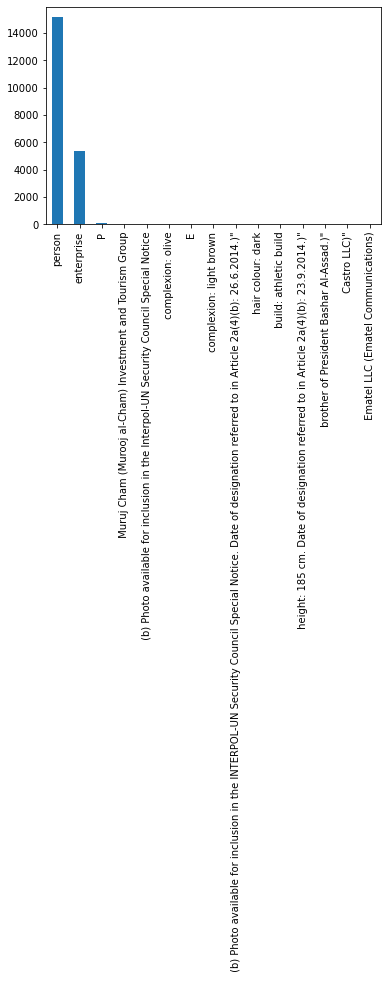

In [23]:
df_ue['Entity_SubjectType_ClassificationCode'].value_counts().plot(kind='bar')

Para casi todos los registros el valor no nulo de 'Entity_SubjectType_ClassificationCode' es 'person' o 'enterprise'. Por lo tanto, se pueden eliminar los otros registros sin que se pierda demasiada información.

In [24]:
warnings.filterwarnings("ignore")

df_ue.replace({None:'0'},inplace=True)

df_ue.drop(df_ue[(df_ue['Entity_SubjectType_ClassificationCode']!='person')&
          (df_ue['Entity_SubjectType_ClassificationCode']!='enterprise')&
          (df_ue['Entity_SubjectType_ClassificationCode']!='0')].index, inplace=True)

df_ue.replace({'0':np.nan},inplace=True)

In [25]:
df_ue['Entity_SubjectType_ClassificationCode'].unique()

array(['person', nan, 'enterprise'], dtype=object)

In [26]:
df_ue_15_30 = df_ue.iloc[:,15:30]
df_ue_15_30.head()

,Entity_Regulation_PublicationUrl,NameAlias_LastName,NameAlias_FirstName,NameAlias_MiddleName,NameAlias_WholeName,NameAlias_NameLanguage,NameAlias_Gender,NameAlias_Title,NameAlias_Function,NameAlias_LogicalId,NameAlias_RegulationLanguage,NameAlias_Remark,NameAlias_Regulation_Type,NameAlias_Regulation_OrganisationType,NameAlias_Regulation_PublicationDate
1,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,Hussein Al-Tikriti,Saddam,,Saddam Hussein Al-Tikriti,,M,,,17,EN,,regulation,commission,2003-07-08
2,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,Abu Ali,,,,,19,EN,,regulation,commission,2003-07-08
3,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,Abou Ali,FR,,,,380,EN,,regulation,commission,2003-07-08
4,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,,,,,,,,,,,
5,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,,,,,,,,,,,


In [27]:
df_ue_15_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21575 entries, 1 to 21795
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Entity_Regulation_PublicationUrl       20556 non-null  object
 1   NameAlias_LastName                     20556 non-null  object
 2   NameAlias_FirstName                    20556 non-null  object
 3   NameAlias_MiddleName                   20556 non-null  object
 4   NameAlias_WholeName                    20556 non-null  object
 5   NameAlias_NameLanguage                 20449 non-null  object
 6   NameAlias_Gender                       20449 non-null  object
 7   NameAlias_Title                        20449 non-null  object
 8   NameAlias_Function                     20419 non-null  object
 9   NameAlias_LogicalId                    19808 non-null  object
 10  NameAlias_RegulationLanguage           19789 non-null  object
 11  NameAlias_Remar

In [28]:
print("La columna con la información del nombre de la entidad es 'NameAlias_WholeName'.\n")

print("Se trata de una variable categórica nominal con",
      len(df_ue['NameAlias_WholeName'].unique()),"valores únicos.\n")

print("Existen",df_ue['NameAlias_WholeName'].isnull().tolist().count(True),
      "valores nulos de un total de",len(df_ue),'valores.')

La columna con la información del nombre de la entidad es 'NameAlias_WholeName'.

Se trata de una variable categórica nominal con 14516 valores únicos.

Existen 1019 valores nulos de un total de 21575 valores.


In [29]:
df_ue_30_45 = df_ue.iloc[:,30:45]
df_ue_30_45.head()

,NameAlias_Regulation_EntryIntoForceDate,NameAlias_Regulation_NumberTitle,NameAlias_Regulation_Programme,NameAlias_Regulation_PublicationUrl,Address_City,Address_Street,Address_PoBox,Address_ZipCode,Address_Region,Address_Place,Address_AsAtListingTime,Address_ContactInfo,Address_CountryIso2Code,Address_CountryDescription,Address_LogicalId
1,2003-07-07,1210/2003 (OJ L169),IRQ,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,,,,,,,,
2,2003-07-07,1210/2003 (OJ L169),IRQ,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,,,,,,,,
3,2003-07-07,1210/2003 (OJ L169),IRQ,http://eur-lex.europa.eu/LexUriServ/LexUriServ...,,,,,,,,,,,
4,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,


In [30]:
df_ue_30_45.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21575 entries, 1 to 21795
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   NameAlias_Regulation_EntryIntoForceDate  19717 non-null  object
 1   NameAlias_Regulation_NumberTitle         19716 non-null  object
 2   NameAlias_Regulation_Programme           19711 non-null  object
 3   NameAlias_Regulation_PublicationUrl      19711 non-null  object
 4   Address_City                             19711 non-null  object
 5   Address_Street                           19549 non-null  object
 6   Address_PoBox                            19247 non-null  object
 7   Address_ZipCode                          19246 non-null  object
 8   Address_Region                           19246 non-null  object
 9   Address_Place                            19245 non-null  object
 10  Address_AsAtListingTime                  19234 non-null  o

In [31]:
print("Las columnas con la información de la ubicación son 'Address_City', 'Address_CountryDescription'.\n")

print("Se tratan de variables categóricas nominales con",
      len(df_ue['Address_City'].unique()),'y',len(df_ue['Address_CountryDescription'].unique()),
      "valores únicos, respectivamente.\n")

print("Existen",df_ue['Address_City'].isnull().tolist().count(True),
      "valores nulos para 'Address_City' y",df_ue['Address_CountryDescription'].isnull().tolist().count(True),
      "para 'Address_CountryDescription' de un total de",len(df_ue),"valores.")

Las columnas con la información de la ubicación son 'Address_City', 'Address_CountryDescription'.

Se tratan de variables categóricas nominales con 384 y 74 valores únicos, respectivamente.

Existen 1864 valores nulos para 'Address_City' y 2388 para 'Address_CountryDescription' de un total de 21575 valores.


El DataFrame de la UE con la información relevante queda como:

In [32]:
df_ue = df_ue.loc[:,['Entity_EU_ReferenceNumber','Entity_SubjectType_ClassificationCode','NameAlias_WholeName',
                        'Address_City','Address_CountryDescription']].reset_index(drop=True)
df_ue.head()

,Entity_EU_ReferenceNumber,Entity_SubjectType_ClassificationCode,NameAlias_WholeName,Address_City,Address_CountryDescription
0,EU.27.28,person,Saddam Hussein Al-Tikriti,,
1,EU.27.28,person,Abu Ali,,
2,EU.27.28,person,Abou Ali,,
3,EU.27.28,person,,,
4,EU.27.28,person,,,


In [33]:
df_ue.to_csv('UE_EEUU_data_crudo/sancionlist2_UE.csv')

La columna de 'Entity_EU_ReferenceNumber' se ha dejado por una razón: Los valores correspondientes a la ubicación no aparecen en el mismo registro que el nombre correspondiente a dicha ubicación. Para poder identificar los valores para la ubicación y moverlos al registro con su correspondiente nombre, es necesario agrupar por la columna 'Entity_EU_ReferenceNumber'. 

A partir del groupby se crea un DataFrame que contiene contiene el país y ciudad asociados a cada número de referencia.

In [34]:
df_ue = pd.read_csv('UE_EEUU_data_crudo/sancionlist2_UE.csv',dtype=str).replace({np.nan:'0'})
df = df_ue.groupby(['Entity_EU_ReferenceNumber'], as_index = False).agg({'Address_City': ';'.join,'Address_CountryDescription': ';'.join})

for element in df.columns:
    df[element] = df[element].str.title()
df['Entity_EU_ReferenceNumber'] = df['Entity_EU_ReferenceNumber'].str.upper()

In [35]:
list_new_city = []
list_new_country = []

for element in range(len(df)):
    string1 = df.loc[element,'Address_City']
    string2 = df.loc[element,'Address_CountryDescription']
    string_pattern = r"(0;[A-Z][a-z]{1,10}[ -'][A-Z][a-z]{1,10}[ -][A-Z][a-z]{1,10})|(0;[A-Z][a-z]{1,10}[ -'][A-Z][a-z]{1,10})|(0;[A-Z][a-z]{1,10})"
    regex_pattern = re.compile(string_pattern)
    result1 = regex_pattern.search(string1)
    result2 = regex_pattern.search(string2)
        
    if result1 != None:
        list_new_city.append(result1.group())
    else:
        list_new_city.append('0;0')
        
    if result2 != None:
        list_new_country.append(result2.group())
    else:
        list_new_country.append('0;0')

In [36]:
df = df.drop(columns=['Address_City','Address_CountryDescription'])
df['Address_City'] = list_new_city
df['Address_CountryDescription'] = list_new_country

df[[0,'Address_City']]=df.Address_City.str.split(';',expand=True)
df[[0,'Address_CountryDescription']]=df.Address_CountryDescription.str.split(';',expand=True)
df=df.drop(columns=[0])

Se obtiene una tabla que relaciona cada ciudad y país con su número de referencia:

In [37]:
df.head(15)

,Entity_EU_ReferenceNumber,Address_City,Address_CountryDescription
0,EU.1001.60,0,0
1,EU.1003.87,0,0
2,EU.1006.79,0,0
3,EU.101.7,0,0
4,EU.1010.96,Tangerang,0
5,EU.1013.88,0,0
6,EU.1014.53,0,0
7,EU.1026.81,0,0
8,EU.103.9,0,0
9,EU.1033.90,0,0


Se hace un outer join para trasladar esta información a la tabla de sancionados principal. Una vez hecho se elimina la columna 'Entity_EU_ReferenceNumber', pues ya no es necesaria.

In [38]:
df_ue = df_ue.loc[:,['Entity_EU_ReferenceNumber','Entity_SubjectType_ClassificationCode','NameAlias_WholeName',
                        'Address_City','Address_CountryDescription']].reset_index(drop=True)
df_ue.drop(columns=['Address_City','Address_CountryDescription'],inplace=True)

df_ue = df_ue.merge(df,how='outer',on='Entity_EU_ReferenceNumber').replace({'0':np.nan}).drop(columns=['Entity_EU_ReferenceNumber'])

In [39]:
df_ue.head()

,Entity_SubjectType_ClassificationCode,NameAlias_WholeName,Address_City,Address_CountryDescription
0,person,Saddam Hussein Al-Tikriti,NaN,NaN
1,person,Abu Ali,NaN,NaN
2,person,Abou Ali,NaN,NaN
3,person,NaN,NaN,NaN
4,person,NaN,NaN,NaN


In [40]:
df_ue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21575 entries, 0 to 21574
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Entity_SubjectType_ClassificationCode  20556 non-null  object
 1   NameAlias_WholeName                    14694 non-null  object
 2   Address_City                           5272 non-null   object
 3   Address_CountryDescription             4111 non-null   object
dtypes: object(4)
memory usage: 842.8+ KB


Finalmente, se almacena este DataFrame en formato .csv en la carpeta 'datos_entrada_script_02'.

In [41]:
df_ue.to_csv('datos_entrada_script_02/df_ue.csv')